## Import Necessary Libraries

In [18]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks
import matplotlib.pyplot as plt
import numpy as np


## Setup Constants

In [19]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50
CHANNELS = 3
FINE_TUNE_EPOCHS = 20
TOTAL_EPOCHS = EPOCHS + FINE_TUNE_EPOCHS


##  Load Dataset

In [20]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "images", shuffle=True, image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE
)
class_names = dataset.class_names


Found 6748 files belonging to 23 classes.


## Define Function to Split Dataset

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds


## Split the Dataset

In [22]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + val_split + test_split) == 1, "Splits must sum up to 1"
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    
    return train_ds, val_ds, test_ds



In [23]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1)


## Apply Data Augmentation

In [24]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


## Define and Compile the Model

In [25]:
base_model = tf.keras.applications.EfficientNetB0(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
optimizer = optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


## Train the Model

In [26]:
history = model.fit(train_ds, validation_data=val_ds, epochs=100, verbose=1)


Epoch 1/100
168/168 [==============================] - 333s 2s/step - loss: 2.2458 - accuracy: 0.3529 - val_loss: 1.4381 - val_accuracy: 0.6310
Epoch 2/100
168/168 [==============================] - 307s 2s/step - loss: 1.4625 - accuracy: 0.5843 - val_loss: 1.0698 - val_accuracy: 0.7098
Epoch 3/100
168/168 [==============================] - 306s 2s/step - loss: 1.2504 - accuracy: 0.6276 - val_loss: 0.8794 - val_accuracy: 0.7500
Epoch 4/100
168/168 [==============================] - 307s 2s/step - loss: 1.1369 - accuracy: 0.6672 - val_loss: 0.8389 - val_accuracy: 0.7723
Epoch 5/100
168/168 [==============================] - 307s 2s/step - loss: 1.0717 - accuracy: 0.6778 - val_loss: 0.8192 - val_accuracy: 0.7545
Epoch 6/100
168/168 [==============================] - 308s 2s/step - loss: 1.0372 - accuracy: 0.6856 - val_loss: 0.7064 - val_accuracy: 0.8036
Epoch 7/100
168/168 [==============================] - 308s 2s/step - loss: 0.9678 - accuracy: 0.7126 - val_loss: 0.6718 - val_accuracy:

## Unfreeze Base Model and Fine-tune

In [31]:
base_model.trainable = True
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=FINE_TUNE_EPOCHS, initial_epoch=history.epoch[-1], callbacks=[early_stopping, model_checkpoint], verbose=1)


## Evaluate and Save Model

In [28]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")
model.save("final_model.h5")


[INFO] Calculating model accuracy
22/22 [==============================] - 46s 2s/step - loss: 0.3931 - accuracy: 0.8849
Test Accuracy: 88.49000000000001%


C:\Users\Micheal\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Plot Training Curves (Optional)

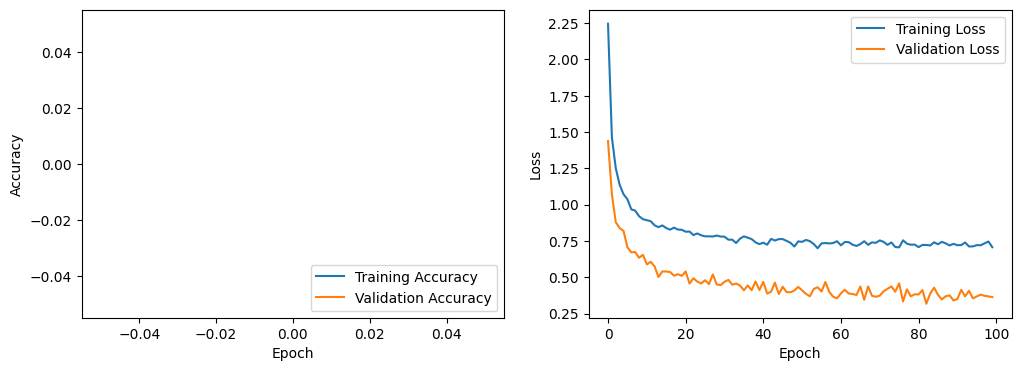

In [32]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history.get('acc', []) + history_fine.history.get('acc', []), label='Training Accuracy')
plt.plot(history.history.get('val_acc', []) + history_fine.history.get('val_acc', []), label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(history.history.get('loss', []) + history_fine.history.get('loss', []), label='Training Loss')
plt.plot(history.history.get('val_loss', []) + history_fine.history.get('val_loss', []), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()


### @clever project